# Bias correction

Decadal means generated for the summer growing season 151st - 270th day $\to$ May 31 - Sep 27.

In [1]:
import xarray as xr
xr.set_options(keep_attrs=True)
import cf_xarray
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import polars as pl
import pprint
import os
import sys
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
%load_ext rich

In [2]:
input_dir = '/Volumes/valencig@bc/DLEM/inputs/'
input_bias_dir = '/Volumes/valencig@bc/DLEM/inputs-bias-corrected/'
comp_dir = os.getcwd()+'/ClimateDataComparison/'
bias_dir = comp_dir + 'Bias/'

In [3]:
def get_file(var, model, decade):
    if var == 'Tavg':
        var = 'avg'
    decade_files =  glob(comp_dir + model + f'/*{decade}s.bin')
    return [f for f in decade_files if var in f][0]

## Simple mean
$$\hat{\text{Bias}} = \bar{x}-\bar{obs}$$
$$x'_i = x_i - \hat{\text{Bias}}$$

## Relative change approach
$$\hat{\text{Rel.Bias}} = \bar{obs}/\bar{x}$$
$$x'_i = x_i \times \hat{\text{Rel.Bias}}$$

In [34]:
variables = {
    'dswrf': 'relative', 
    'pr': 'relative', 
    'Tavg': 'mean', 
    'Tmin': 'mean', 
    'Tmax': 'mean'
}
print(f'Directories containing bias correction factors will be created in `{bias_dir}`')
print(f'Directories containing bias corrected data will be created in `{input_bias_dir}`')
for var, approach in tqdm(variables.items(), desc='Processing DLEM inputs', file=sys.stdout):
    var_dir = bias_dir + var + '/'
    var_input_dir = input_bias_dir + var.lower() + '/'
    if not os.path.exists(var_dir):
        os.makedirs(var_dir)
    if not os.path.exists(var_input_dir):
        os.makedirs(var_input_dir)
    for decade in [1970, 1980, 1990, 2000]:
        cesm2 = np.fromfile(get_file(var, 'CESM2Stat/CESM2', decade), dtype=np.float32).reshape([292, 693])
        dlem = np.fromfile(get_file(var, 'DLEMStat/DLEM', decade), dtype=np.float32).reshape([292, 693])
        # Get files to bias correct
        years = [str(y) for y in np.arange(decade, decade+10)]
        input_files = [f for f in sorted(glob(input_dir + var.lower() + '/*.bin')) if any(y in f for y in years)]
        if approach == 'relative':
            bias = dlem/cesm2
            for f in input_files:
                data = np.fromfile(f, dtype=np.float32).reshape([365, 292, 693])
                data = data * bias
                data.tofile(var_input_dir + f.split('/')[-1])
        elif approach == 'mean':
            bias = cesm2 - dlem
            for f in input_files:
                data = np.fromfile(f, dtype=np.float32).reshape([365, 292, 693])
                data = data - bias
                data.tofile(var_input_dir + f.split('/')[-1])
        bias.tofile(var_dir + f'{var}_{decade}_{approach}_bias.bin')
    
    
    

Directories containing bias correction factors will be created in `/Users/ilanvalencius/Documents/PhD-courses/2-Global-Sustainability/final-project/ClimateDataComparison/Bias/`
Directories containing bias corrected data will be created in `/Volumes/valencig@bc/DLEM/inputs-bias-corrected/`
Processing DLEM inputs: 100%|██████████| 3/3 [38:14<00:00, 764.81s/it]


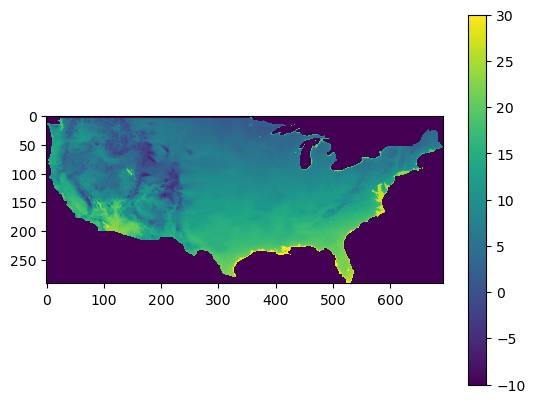

In [37]:
foo = np.fromfile('/Volumes/valencig@bc/DLEM/inputs-bias-corrected/tavg/tavg2009.bin', dtype=np.float32).reshape([365, 292, 693])
yearly_mean = np.mean(foo, axis=0)
plt.imshow(yearly_mean, vmin=-10, vmax=30)
plt.colorbar()
plt.show()

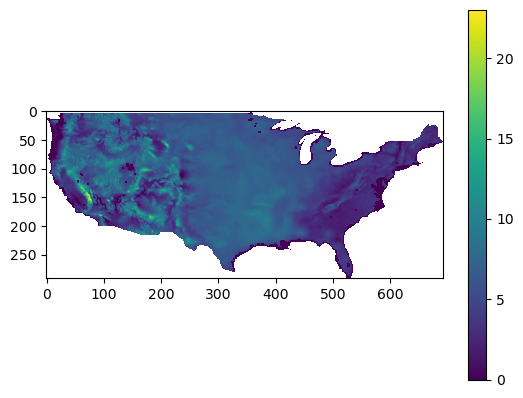

In [51]:
foo = np.fromfile('ClimateDataComparison/Bias/Tavg/Tavg_2000_mean_bias.bin', dtype=np.float32).reshape([292, 693])
foo[foo == 0] = np.nan
plt.imshow(foo, vmin=0)
plt.colorbar()
plt.show()